In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
#pd.options.display.max_colwidth = 200
%matplotlib inline

In [3]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [7]:
from gensim.models import word2vec

#tokenize sentences in corpus
tokenized_corpus=[wpt.tokenize(document) for document in norm_bible]

#set values for various parameters
feature_size=100 #Word vector dimensionality
window_context=30 #Context window size
min_word_count=1 #Minimum word count
sample=1e-3 #Downsample setting for frequent words

w2v_model=word2vec.Word2Vec(tokenized_corpus,size=feature_size,window=window_context,
                            min_count=min_word_count,sample=sample,iter=50)

#View similar words based on gensim's model
similar_words={search_term: [item[0] for item in w2v_model.wv.most_similar([search_term],topn=5)]
               for search_term in ['god','jesus','noah','egypt','john','gospel','moses','famine']}

similar_words

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'egypt': ['egyptians', 'pharaoh', 'bondage', 'flowing', 'rid'],
 'famine': ['pestilence', 'peril', 'deaths', 'overtaketh', 'trespassing'],
 'god': ['lord', 'worldly', 'sworn', 'established', 'rebellion'],
 'gospel': ['christ', 'persecutions', 'faith', 'afflictions', 'hope'],
 'jesus': ['peter', 'messias', 'apelles', 'immediately', 'john'],
 'john': ['baptist', 'james', 'devine', 'peter', 'baptize'],
 'moses': ['joshua', 'congregation', 'children', 'naashon', 'elisheba'],
 'noah': ['shem', 'ham', 'japheth', 'kenan', 'enosh']}

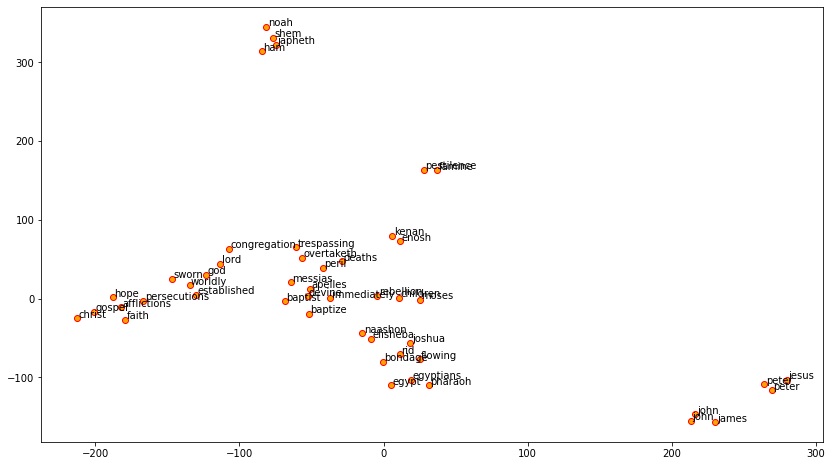

In [8]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')